### Beating the Imbalance with Oversampling using SMOTE & its Variants

In this notebook, we will deal with an imbalanced churn classification problem and use oversamlling techniques such as SMOTE, SVM SMOTE, K-Means SMOTE to see how much they can help us in comparison to random oversampling or not oversmapling at all.

Note: The focus of this notebook is to show how to do overampling and less on other ML aspects.

## Imports

In [1]:
import pandas as pd
import numpy as np
import imblearn
from sklearn.metrics import classification_report
import pyintellify
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE 
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
pyintellify.setmpl()

## Load Data

In [3]:
df = pd.read_csv('teleco_churn_dataset.csv')

## Some data inspection

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
#No null values so we can get started with the model
df.isnull().values.sum()

0

No     5174
Yes    1869
Name: Churn, dtype: int64


<AxesSubplot:>

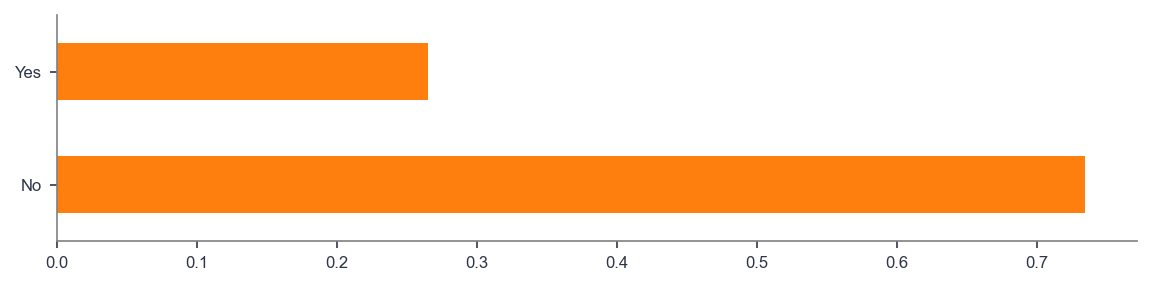

In [6]:
#Dataset Imbalance
print(df['Churn'].value_counts())
fig = plt.figure(figsize = (9,2))
df['Churn'].value_counts(normalize = True).plot.barh()

#### So that's approximately a 70/30 imbalance

## Feature Selection

#### I am only going to select some numerical features so we can use the above mentioned oversampling methods and keep it simple.
#### Categorical features can be encoded or we can use SMOTE-NC to deal with this situation but that's not the aim here.

In [7]:
selected_cols = [col for col in df.columns if df[col].dtype == float] + ['tenure'] + ['Churn']

In [8]:
selected_cols

['MonthlyCharges', 'tenure', 'Churn']

In [9]:
df = df[selected_cols]

In [10]:
df

,MonthlyCharges,tenure,Churn
0,29.85,1,No
1,56.95,34,No
2,53.85,2,Yes
3,42.30,45,No
4,70.70,2,Yes
...,...,...,...
7038,84.80,24,No
7039,103.20,72,No
7040,29.60,11,No
7041,74.40,4,Yes


## Dataset Splitting

In [11]:
train, test = train_test_split(df, test_size = 0.25, random_state = 42, stratify = df['Churn'])
X_train, y_train, X_test, y_test = train.drop(['Churn'], axis = 1), train['Churn'], \
                                   test.drop(['Churn'], axis = 1), test['Churn']

In [12]:
y_train.shape, y_train.value_counts()

((5282,),
 No     3880
 Yes    1402
 Name: Churn, dtype: int64)

### Let's vizualize the data spread

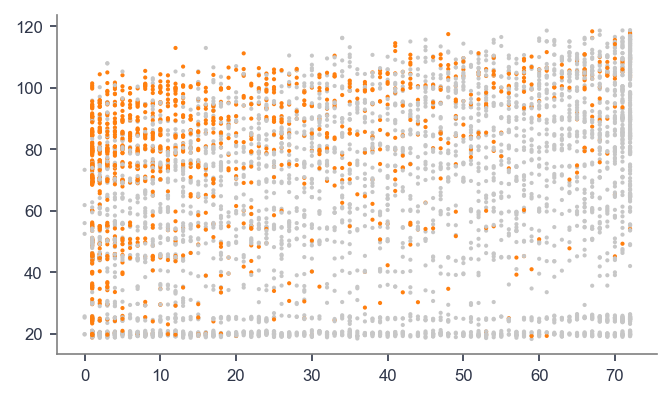

In [13]:
#Data Spread

colors = [pyintellify.tableau21[18] if label == 'No' else pyintellify.tableau21[0] for label in y_train]
plt.scatter(X_train['tenure'], X_train['MonthlyCharges'], linewidth = 1, color = colors, s = 1)

### This hardly looks linearly separable

## Normalization

#### I am going to use a random forest for the classification task so there's no need to normalize actually. However, since KMeans SMOTE relies on the KMeans algorithm, doing some form of scaling will be useful.

#### Since the features we take don't have negative values (and it doesn't make sense for them to have negative values) I am going to do normalization



In [14]:
normalizer = MinMaxScaler()
X_train = pd.DataFrame(normalizer.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(normalizer.transform(X_test), columns = X_test.columns)

In [15]:
display(X_train)
display(X_test)

,MonthlyCharges,tenure
0,0.351271,1.000000
1,0.275037,0.055556
2,0.027902,0.777778
3,0.757848,0.777778
4,0.609367,0.125000
...,...,...
5277,0.857997,0.875000
5278,0.327354,0.013889
5279,0.905331,0.986111
5280,0.019930,0.333333


,MonthlyCharges,tenure
0,0.615845,0.722222
1,0.058296,0.458333
2,0.351769,0.138889
3,0.663677,0.013889
4,0.316891,0.722222
...,...,...
1756,0.574489,0.486111
1757,0.704036,0.180556
1758,0.817638,0.541667
1759,0.125561,0.041667


## Oversampling

### Random Oversampling

In [16]:
random_os = RandomOverSampler(random_state = 42)
X_random, y_random = random_os.fit_resample(X_train, y_train)

In [17]:
X_random.shape, y_random.shape

((7760, 2), (7760,))

In [18]:
y_random.value_counts()

No     3880
Yes    3880
Name: Churn, dtype: int64

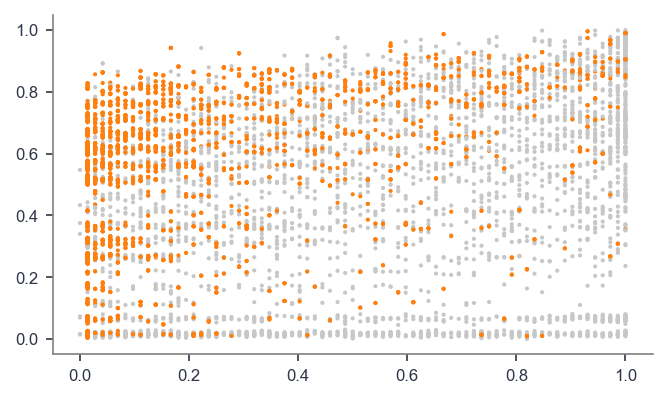

In [19]:
#Data Spread
colors = [pyintellify.tableau21[18] if label == 'No' else pyintellify.tableau21[0] for label in y_random]
plt.scatter(X_random['tenure'], X_random['MonthlyCharges'], linewidth = 1, color = colors, s = 1)

### SMOTE

In [20]:
smote_os = SMOTE(random_state = 42)
X_smote, y_smote = smote_os.fit_resample(X_train, y_train)

In [21]:
y_smote.value_counts()

No     3880
Yes    3880
Name: Churn, dtype: int64

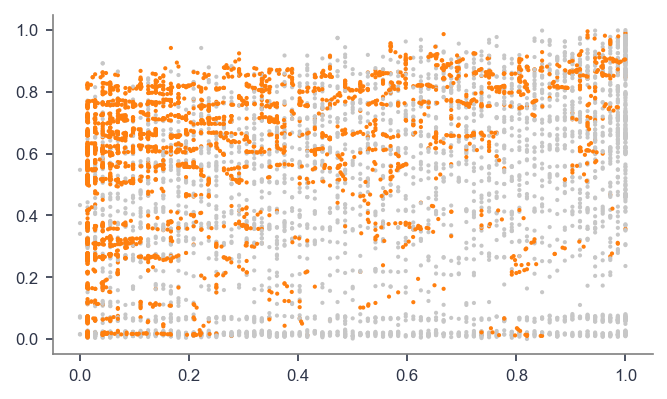

In [22]:
colors = [pyintellify.tableau21[18] if label == 'No' else pyintellify.tableau21[0] for label in y_smote]
plt.scatter(X_smote['tenure'], X_smote['MonthlyCharges'], linewidth = 1, color = colors, s = 1)

### BorderlineSMOTE

In [23]:
smote_border = BorderlineSMOTE(random_state = 42, kind = 'borderline-2')
X_smoteborder, y_smoteborder = smote_border.fit_resample(X_train, y_train)

In [24]:
y_smoteborder.value_counts()

No     3880
Yes    3880
Name: Churn, dtype: int64

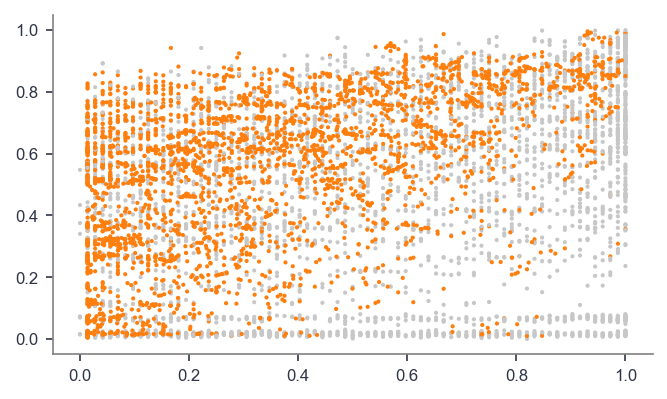

In [25]:
colors = [pyintellify.tableau21[18] if label == 'No' else pyintellify.tableau21[0] for label in y_smoteborder]
plt.scatter(X_smoteborder['tenure'], X_smoteborder['MonthlyCharges'], linewidth = 1, color = colors, s = 1)

In [26]:
X_smoteborder.shape

(7760, 2)

### SVM SMOTE

In [26]:
smote_svm = SVMSMOTE(random_state = 42)
X_smotesvm, y_smotesvm = smote_svm.fit_resample(X_train, y_train)

In [27]:
y_smotesvm.value_counts()

No     3880
Yes    3880
Name: Churn, dtype: int64

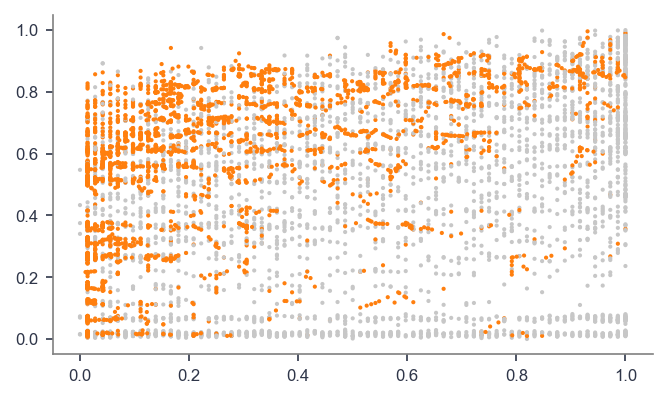

In [28]:
colors = [pyintellify.tableau21[18] if label == 'No' else pyintellify.tableau21[0] for label in y_smotesvm]
plt.scatter(X_smotesvm['tenure'], X_smotesvm['MonthlyCharges'], linewidth = 1, color = colors, s = 1)

In [29]:
X_smotesvm.shape

(7760, 2)

### K-Means SMOTE

In [30]:
smote_kmeans = KMeansSMOTE(random_state = 42)
X_smotekmeans, y_smotekmeans = smote_kmeans.fit_resample(X_train, y_train)

In [31]:
y_smotekmeans.value_counts()

No     3880
Yes    3880
Name: Churn, dtype: int64

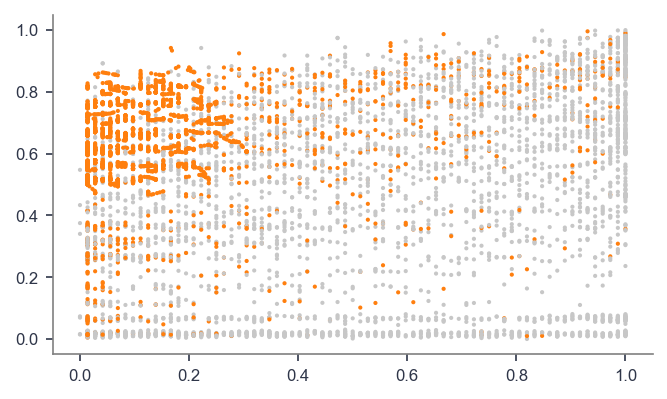

In [32]:
colors = [pyintellify.tableau21[18] if label == 'No' else pyintellify.tableau21[0] for label in y_smotekmeans]
plt.scatter(X_smotekmeans['tenure'], X_smotekmeans['MonthlyCharges'], linewidth = 1, color = colors, s = 1)

## ML Model Building

In [33]:
comparison_sets = [(X_train, y_train), (X_random, y_random), (X_smote, y_smote), (X_smoteborder, y_smoteborder), (X_smotesvm, y_smotesvm), (X_smotekmeans, y_smotekmeans)]

In [34]:
rf = RandomForestClassifier(random_state = 42, max_depth = 5)

In [35]:
for i in range(0, len(comparison_sets)):
    rf.fit(comparison_sets[i][0], comparison_sets[i][1])
    print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

          No       0.81      0.92      0.86      1294
         Yes       0.65      0.40      0.50       467

    accuracy                           0.78      1761
   macro avg       0.73      0.66      0.68      1761
weighted avg       0.77      0.78      0.76      1761

              precision    recall  f1-score   support

          No       0.88      0.73      0.80      1294
         Yes       0.49      0.72      0.59       467

    accuracy                           0.73      1761
   macro avg       0.69      0.73      0.69      1761
weighted avg       0.78      0.73      0.74      1761

              precision    recall  f1-score   support

          No       0.88      0.73      0.80      1294
         Yes       0.49      0.72      0.59       467

    accuracy                           0.73      1761
   macro avg       0.69      0.73      0.69      1761
weighted avg       0.78      0.73      0.74      1761

              preci

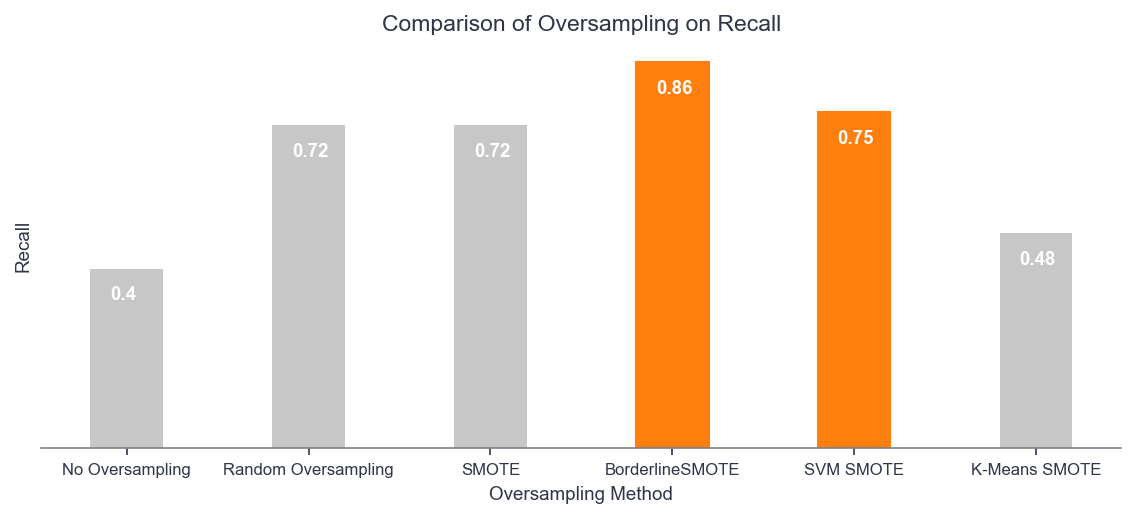

In [37]:
#Copying the results for graphing
versions = ['No Oversampling', 'Random Oversampling', 'SMOTE', 'BorderlineSMOTE', 'SVM SMOTE', 'K-Means SMOTE']
recalls = [0.40, 0.72, 0.72, 0.86, 0.75, 0.48]

fig = plt.figure(figsize = (8,3))
ax = fig.add_axes([0,0,0.9,0.9])
plt.bar(x = versions, height = recalls, width = 0.4, color = pyintellify.tableau21[18])
plt.title('Comparison of Oversampling on Recall')
ax.yaxis.set_ticks([])
ax.spines['left'].set_visible(False)
plt.xlabel('Oversampling Method')
plt.ylabel('Recall')
for i, v in enumerate(recalls):
    ax.text(i - 0.09, v - 0.07, str(v), color = 'white', size = 9, weight = 'bold')
ax.get_children()[3].set_color(pyintellify.tableau21[0])
ax.get_children()[4].set_color(pyintellify.tableau21[0])
plt.show()